In [1]:
# imports
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import cv2 
import random
import sys
import time
from tqdm.notebook import tqdm

In [2]:
# Download dataset
!mkdir ~/.kaggle # create a kaggle folder in the root directory
!echo '{"username":"manpabarman","key":"fb51bde6b491583a924e4ec5968d36b0"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [3]:
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda -p /content/kaggle/

 97% 364M/376M [00:03<00:00, 121MB/s]
100% 376M/376M [00:03<00:00, 117MB/s]


In [4]:
!unzip /content/kaggle/animal-image-datasetdog-cat-and-panda.zip
!rm -r /content/kaggle/animal-image-datasetdog-cat-and-panda.zip
!rm -r /content/kaggle

Streaming output truncated to the last 5000 lines.
  inflating: animals/animals/dogs/dogs_00007.jpg  
  inflating: animals/animals/dogs/dogs_00008.jpg  
  inflating: animals/animals/dogs/dogs_00009.jpg  
  inflating: animals/animals/dogs/dogs_00010.jpg  
  inflating: animals/animals/dogs/dogs_00011.jpg  
  inflating: animals/animals/dogs/dogs_00012.jpg  
  inflating: animals/animals/dogs/dogs_00013.jpg  
  inflating: animals/animals/dogs/dogs_00014.jpg  
  inflating: animals/animals/dogs/dogs_00015.jpg  
  inflating: animals/animals/dogs/dogs_00016.jpg  
  inflating: animals/animals/dogs/dogs_00017.jpg  
  inflating: animals/animals/dogs/dogs_00018.jpg  
  inflating: animals/animals/dogs/dogs_00019.jpg  
  inflating: animals/animals/dogs/dogs_00020.jpg  
  inflating: animals/animals/dogs/dogs_00021.jpg  
  inflating: animals/animals/dogs/dogs_00022.jpg  
  inflating: animals/animals/dogs/dogs_00023.jpg  
  inflating: animals/animals/dogs/dogs_00024.jpg  
  inflating: animals/animals/do

In [5]:
# Define the categories and path
categories = ["cats","dogs","panda"]
path = '/content/animals/animals/'

In [6]:
# inspect the shapes of images if they are same or not
shape0 = []
shape1 = []

for category in categories:
  for files in os.listdir(path+category)[:3]:
    img_read = cv2.imread(path+category+'/'+files)
    shape0.append(img_read.shape[0])
    shape1.append(img_read.shape[1])
print(shape0)
print(shape1)


[376, 459, 375, 244, 364, 154, 375, 491, 375]
[500, 323, 499, 252, 204, 179, 500, 500, 500]


In [7]:
# If sizes are differnet resize the images
image_data = []
height = 50
width = 50
labels = []

for i, category in enumerate(categories):
  for files in os.listdir(path+category):
    image = cv2.imread(path+category+'/'+files)
    image = cv2.resize(image,(width,height))
    image_data.append(image)
    label = i
    labels.append(label)

In [8]:
# test if the resizing is okay
print(len(labels))
print(len(image_data))
print(image.shape)

3000
3000
(50, 50, 3)


In [9]:
# standerdize the images in the range [0,1]
image_data = np.array(image_data,dtype = "float")/255
labels = np.array(labels)

In [10]:
# Define the model
def build_model(input_size,animal_class):
  input = Input(shape= input_size)
  conv1 = keras.layers.Conv2D(16, (2*2), (1*1), padding= "same", activation="relu", name = "Conv_Layer_1")(input)
  max_pool1 = keras.layers.MaxPooling2D(pool_size=2)(conv1)
  conv2 = keras.layers.Conv2D(32, (2*2), (1*1), padding= "same", activation="relu", name = "Conv_Layer_2")(max_pool1)
  max_pool2 = keras.layers.MaxPooling2D(pool_size=2)(conv2)
  conv3 = keras.layers.Conv2D(64, (2*2), (1*1), padding= "same", activation="relu", name = "Conv_Layer_3")(max_pool2)
  max_pool3 = keras.layers.MaxPooling2D(pool_size=2)(conv3)
  dropout_1 = keras.layers.Dropout(0.2)(max_pool3)
  flatten = keras.layers.Flatten()(dropout_1)
  dense_1 =keras.layers.Dense(500,activation="relu")(flatten)
  dropout_2 = keras.layers.Dropout(0.2)(dense_1)
  output =keras.layers.Dense(animal_class,activation="softmax")(dropout_2)
  model = keras.Model(inputs=input, outputs=output)

  return model

#model = build_model(input_size,animal_class)
#model.summary()

In [11]:
# Function to utilize Gradient tape during training
def step(X, y):
  # keep track of our gradients
  with tf.GradientTape() as tape:
		# make a prediction using the model and then calculate the
		# loss
    pred = model(X)
    loss = categorical_crossentropy(y, pred)
    total_loss = tf.reduce_sum(loss)
	# calculate the gradients using our tape and then update the
	# model weights
  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss.numpy()

In [12]:
# Initialize
input_size = image.shape
epochs = 50
batch_size = 100
lr_ = 1e-3
animal_class = 3

In [13]:
# split the data into train and test set(80%-train and 20%-test)
(trainX, testX, trainY, testY) = train_test_split(image_data, labels, test_size=0.2, random_state=42)

#one-hot encode the labels
trainY = np_utils.to_categorical(trainY, animal_class)
testY= np_utils.to_categorical(testY, animal_class)

#check the shapes 
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(2400, 50, 50, 3)
(600, 50, 50, 3)
(2400, 3)
(600, 3)


In [14]:
# build our model
model = build_model(input_size,animal_class)
opt = Adam(lr=lr_, decay=lr_ / epochs)

In [15]:
# train our model 
num_of_batches = int(trainX.shape[0] / batch_size)

for epoch in range(0, epochs):
    print("[INFO] starting epoch {}/{}...".format(
        epoch + 1,epochs), end=" ")
    sys.stdout.flush()
    epochStart = time.time()
    t =  tqdm(range(num_of_batches))
    for i in t:
        start = i * batch_size
        end = start + batch_size
        loss = step(trainX[start:end], trainY[start:end])
        message = "total loss: {}".format(str(loss))
        t.set_postfix_str(message)
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("Time elapsed = {:.4} minutes".format(elapsed)) # {:.4} is for output padding

[INFO] starting epoch 1/50... 


Time elapsed = 0.1707 minutes
[INFO] starting epoch 2/50... 


Time elapsed = 0.1656 minutes
[INFO] starting epoch 3/50... 


Time elapsed = 0.1655 minutes
[INFO] starting epoch 4/50... 


Time elapsed = 0.1644 minutes
[INFO] starting epoch 5/50... 


Time elapsed = 0.1645 minutes
[INFO] starting epoch 6/50... 


Time elapsed = 0.1657 minutes
[INFO] starting epoch 7/50... 


Time elapsed = 0.1654 minutes
[INFO] starting epoch 8/50... 


Time elapsed = 0.1655 minutes
[INFO] starting epoch 9/50... 


Time elapsed = 0.1655 minutes
[INFO] starting epoch 10/50... 


Time elapsed = 0.1661 minutes
[INFO] starting epoch 11/50... 


Time elapsed = 0.1661 minutes
[INFO] starting epoch 12/50... 


Time elapsed = 0.1658 minutes
[INFO] starting epoch 13/50... 


Time elapsed = 0.1659 minutes
[INFO] starting epoch 14/50... 


Time elapsed = 0.1654 minutes
[INFO] starting epoch 15/50... 


Time elapsed = 0.1664 minutes
[INFO] starting epoch 16/50... 


Time elapsed = 0.1659 minutes
[INFO] starting epoch 17/50... 


Time elapsed = 0.1656 minutes
[INFO] starting epoch 18/50... 


Time elapsed = 0.1694 minutes
[INFO] starting epoch 19/50... 


Time elapsed = 0.1659 minutes
[INFO] starting epoch 20/50... 


Time elapsed = 0.1658 minutes
[INFO] starting epoch 21/50... 


Time elapsed = 0.1655 minutes
[INFO] starting epoch 22/50... 


Time elapsed = 0.1662 minutes
[INFO] starting epoch 23/50... 


Time elapsed = 0.1666 minutes
[INFO] starting epoch 24/50... 


Time elapsed = 0.1658 minutes
[INFO] starting epoch 25/50... 


Time elapsed = 0.1652 minutes
[INFO] starting epoch 26/50... 


Time elapsed = 0.1651 minutes
[INFO] starting epoch 27/50... 


Time elapsed = 0.1676 minutes
[INFO] starting epoch 28/50... 


Time elapsed = 0.1705 minutes
[INFO] starting epoch 29/50... 


Time elapsed = 0.1685 minutes
[INFO] starting epoch 30/50... 


Time elapsed = 0.1667 minutes
[INFO] starting epoch 31/50... 


Time elapsed = 0.1672 minutes
[INFO] starting epoch 32/50... 


Time elapsed = 0.1668 minutes
[INFO] starting epoch 33/50... 


Time elapsed = 0.1669 minutes
[INFO] starting epoch 34/50... 


Time elapsed = 0.1662 minutes
[INFO] starting epoch 35/50... 


Time elapsed = 0.1672 minutes
[INFO] starting epoch 36/50... 


Time elapsed = 0.1671 minutes
[INFO] starting epoch 37/50... 


Time elapsed = 0.1664 minutes
[INFO] starting epoch 38/50... 


Time elapsed = 0.1665 minutes
[INFO] starting epoch 39/50... 


Time elapsed = 0.1942 minutes
[INFO] starting epoch 40/50... 


Time elapsed = 0.2012 minutes
[INFO] starting epoch 41/50... 


Time elapsed = 0.1667 minutes
[INFO] starting epoch 42/50... 


Time elapsed = 0.1666 minutes
[INFO] starting epoch 43/50... 


Time elapsed = 0.1672 minutes
[INFO] starting epoch 44/50... 


Time elapsed = 0.1664 minutes
[INFO] starting epoch 45/50... 


Time elapsed = 0.1666 minutes
[INFO] starting epoch 46/50... 


Time elapsed = 0.167 minutes
[INFO] starting epoch 47/50... 


Time elapsed = 0.1664 minutes
[INFO] starting epoch 48/50... 


Time elapsed = 0.1692 minutes
[INFO] starting epoch 49/50... 


Time elapsed = 0.1672 minutes
[INFO] starting epoch 50/50... 


Time elapsed = 0.1665 minutes


In [19]:
# calculate the accuracy against the real and predicted output
model.compile(optimizer=opt, loss=categorical_crossentropy,metrics=["acc"])
(loss, acc) = model.evaluate(testX, testY)
print("[INFO] test accuracy: {:.4f}".format(acc))

19/19 [==============================] - 1s 30ms/step - loss: 2.2087 - acc: 0.7122
[INFO] test accuracy: 0.7000


In [20]:
#test my model
img = cv2.imread('/content/animals/images/panda.jpg')
img = cv2.resize(img,(width,height))
img = np.expand_dims(img,axis = 0)
img.shape
out_array = model.predict(img)
categories[out_array.argmax(axis=1)[-1]]

'panda'

'panda'

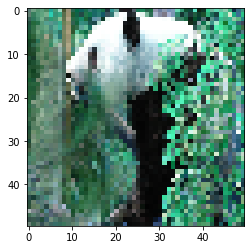

In [21]:
idx = random.randint(0, len(image_data))
rand_img = image_data[idx]
plt.imshow(rand_img)
rand_img = np.expand_dims(rand_img,axis = 0)
out_array = model.predict(rand_img)
categories[out_array.argmax(axis=1)[-1]]